In [132]:
## fairseq_code_analysis/joeynmt_notebooks/my_pytorch_transformer.ipynb

In [1]:
import torch
import torch.nn as nn

class PositionalEncoding2(nn.Module):
    """
    Pre-compute position encodings (PE).
    In forward pass, this adds the position-encodings to the
    input for as many time steps as necessary.

    Implementation based on OpenNMT-py.
    https://github.com/OpenNMT/OpenNMT-py
    """
    def __init__(self,
                 size: int = 0,
                 max_len: int = 5000):
        """
        Positional Encoding with maximum length max_len
        :param size:
        :param max_len:
        :param dropout:
        """
        if size % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dim (got dim={:d})".format(size))
        pe = torch.zeros(max_len, size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, size, 2, dtype=torch.float) *
                              -(torch.log(torch.tensor(10000.)) / size)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, size, max_len]
        super().__init__()
        self.register_buffer('pe', pe)
        self.dim = size

    def forward(self, emb):
        """Embed inputs.
        Args:
            emb (FloatTensor): Sequence of word vectors
                ``(seq_len, batch_size, self.dim)``
        """
        # Add position encodings
        return emb + self.pe[:, :emb.size(1)]

In [47]:
#https://d2l.ai/chapter_attention-mechanisms/transformer.html#positional-encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_emb, dropout, max_len=100):
        if d_emb % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with odd dim (got dim={:d})".format(d_emb))
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, d_emb))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(
            0, d_emb, 2, dtype=torch.float32) / d_emb)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X): #  (b,l,d): where  l  is the sequence length and  d  is the embedding size
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

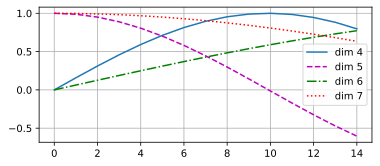

In [48]:
from d2l import torch as d2l
b=1;l=15;d=num_hiddens=20; max_len=30

pe = PositionalEncoding(d_emb=num_hiddens, dropout=0., max_len=max_len)
pe.eval()
X_emb=torch.zeros((1, l, d))
Y = pe(X_emb) #  (b,l,d)
d2l.plot(torch.arange(l), Y[0, :, 4:8].T, figsize=(6, 2.5),legend=["dim %d" % p for p in [4, 5, 6, 7]])

In [44]:
Y.shape,X_emb.shape

(torch.Size([1, 15, 20]), torch.Size([1, 15, 20]))

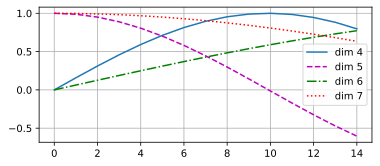

In [45]:
pe = PositionalEncoding2(size=num_hiddens, max_len=max_len)
pe.eval()
X_emb=torch.zeros((1, l, d))
Y = pe(X_emb) #  (b,l,d)
d2l.plot(torch.arange(l), Y[0, :, 4:8].T, figsize=(6, 2.5),legend=["dim %d" % p for p in [4, 5, 6, 7]])

In [124]:
from typing import Optional , Any , Union
class JqTransformer(nn.Module):
    def __init__(self,max_src_len:int=100, max_tgt_len:int=100, vocab_size_src=1000, vocab_size_tgt=1000,
                 d_emb: int = 512, padding_idx: int = None,
                 d_model: int = 512, nhead: int = 8, 
                 num_encoder_layers: int = 2, num_decoder_layers: int = 2, 
                 dim_feedforward: int = 2048, dropout: float = 0.1, 
                 activation: str = 'relu', custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None):
        """
        
        """
        super().__init__()
        self.padding_idx=padding_idx
        
        self.emb_src=nn.Embedding(num_embeddings=vocab_size_src,embedding_dim=d_emb)
        self.emb_src=nn.Embedding(num_embeddings=vocab_size_tgt,embedding_dim=d_emb)
        self.pos_src=PositionalEncoding(d_emb=d_emb, dropout=dropout, max_len=max_src_len)
        self.pos_tgt=PositionalEncoding(d_emb=d_emb, dropout=dropout, max_len=max_tgt_len)
        self.transformer=nn.Transformer(d_model = d_model, nhead=nhead, 
                                        num_encoder_layers = num_encoder_layers, num_decoder_layers = num_decoder_layers, 
                                        dim_feedforward = dim_feedforward, dropout = dropout, 
                                        activation = activation , custom_encoder = custom_encoder, custom_decoder = custom_decoder)
        self.lin = nn.Linear(in_features=d_model, out_features= vocab_size_tgt)
        
    def forward(self, src_idx, tgt_idx,
                    src_attn_mask=None,tgt_attn_mask=None,memory_attn_mask=None,
                    src_key_padding_mask=None,tgt_key_padding_mask=None,
                    memory_key_padding_mask=None):
        '''
        S: is the source sequence length,
        T: is the target sequence length,
        N: is the batch size, E is the feature number
        
        # 源、目标的输入参数构造
        src_idx: (N,S). 例如： src_idx=torch.randint(0, 11, (N,S))
        tgt_idx: (N,T). 例如： tgt_idx=torch.randint(0, 11, (N,T))
        
        # Attention相关的输入参数构造
        src_attn_mask: (S,S),
        tgt_attn_mask: (T, T)  例如： tgt_attn_mask = self.transformer.generate_square_subsequent_mask(sz=T)
        memory_attn_mask: (T, S)
        
        
        Padding_mask相关的输入参数构造
        src_key_padding_mask: (N,S),  例如：  src_key_padding_mask=(src_idx==self.padding_idx)
        tgt_key_padding_mask: (N, T),  例如： tgt_key_padding_mask=(tgt_idx==self.padding_idx)
        memory_key_padding_mask: (N, S),  默认为None 
        
        '''
        
        # Attention相关的输入参数构造
        if tgt_attn_mask is None:
            T=tgt_idx.size(1)
            tgt_attn_mask = self.transformer.generate_square_subsequent_mask(sz=T)
            src_attn_mask=None
            memory_attn_mask=None
            
        # Padding_mask相关的输入参数构造
        if src_key_padding_mask is None:
            src_key_padding_mask=(src_idx==self.padding_idx)
        if tgt_key_padding_mask is None:
            tgt_key_padding_mask=(tgt_idx==self.padding_idx)
            
        # Embedding + PositionalEncoding
        src_emb=self.emb_src(src_idx)
        src_emb=self.pos_src(src_emb)
        
        tgt_emb=self.emb_src(tgt_idx)
        tgt_emb=self.pos_src(tgt_emb)
        
        # transformer需要的src_emb: `(S, N, E)`.
        # transformer需要的tgt_emb:`(T, N, E)`.
        src_emb=src_emb.permute(1,0,2)
        tgt_emb=tgt_emb.permute(1,0,2)
        
        
        out=self.transformer(src_emb, tgt_emb,
                    src_mask=src_attn_mask,tgt_mask=tgt_attn_mask,memory_mask=memory_attn_mask,
                    src_key_padding_mask=src_key_padding_mask,tgt_key_padding_mask=tgt_key_padding_mask,memory_key_padding_mask=None)
        out=self.lin(out)
        return out.permute(1,0,2)
            


In [125]:
padding_idx=1
N=2
S=5
T=10
vocab_size_src=vocab_size_tgt=11
src_idx=torch.randint(0, 11, (N,S))
tgt_idx=torch.randint(0, 11, (N,T))

In [126]:
src_idx

tensor([[6, 5, 2, 7, 5],
        [9, 5, 3, 8, 1]])

In [127]:
tgt_idx

tensor([[ 3,  4, 10,  1,  5,  4,  5,  4,  6,  0],
        [ 1,  6,  5,  6,  7,  5,  0,  1, 10,  5]])

In [128]:
jqt=JqTransformer(padding_idx=padding_idx,vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt )

In [129]:
out=jqt(src_idx,tgt_idx)

In [130]:
out.shape

torch.Size([2, 10, 11])

In [131]:
tgt_idx.shape

torch.Size([2, 10])

In [58]:
nn.Linear??

Init signature: nn.Linear(in_features: int, out_features: int, bias: bool = True) -> None
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :